In [97]:
import numpy as np
import scipy as sp
import scipy.integrate as it
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from scipy.integrate import quad
from tqdm import tqdm
from scipy import constants
from scipy.constants import c
from scipy.interpolate import interp1d
import emcee
import corner
%matplotlib inline

In [3]:
# Function to set the data and covariance matrix

# Example usage of process_data_and_covariance
data_file_path = './DATA/Pantheon+SH0ES.txt'
cov_file_path = './DATA/Pantheon+SH0ES_STAT+SYS.txt'

def Set_SN(data_file_path, cov_file_path):
    data = np.genfromtxt(data_file_path, skip_header=1)

    # To read Position of RA and DEC
    with open(data_file_path, 'r') as file:
        titles = file.readline().split() 
        index_ra = titles.index('RA')
        index_dec = titles.index('DEC')

    wh = (data[:, 2] > 0.01) # redshift cut
    zhel = data[wh, 6] # heliocentric redshift
    zcmb = data[wh, 2] # peculiar velocity corrected cmb redshift 
    mbs = data[wh, 8] # corrected appearent magnitude
    ra = data[wh, index_ra] # right ascension
    dec = data[wh, index_dec] # declination

    with open(cov_file_path, 'r') as file:
        cov = np.loadtxt(file, skiprows=1)

    n = int(round(np.sqrt(len(cov))))
    cov = np.reshape(cov, (n, n))

    mask = np.array(wh, bool)
    cov = cov[mask][:, mask]


    return zcmb, zhel, mbs, cov, ra, dec

zcmb, zhel, mbs, cov = Set_SN(data_file_path, cov_file_path)[:4]

In [4]:
# Set redshifts for the interpolation
z_max = 3.0
z_min = 0.001
z_len = 1000
z_list = np.linspace(z_min, z_max, z_len)

def E_z(z, Omega_m= 0.3, Omega_de = 0.7, Omega_k = 0.0 ):
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_de)

def curvature_factor(z, Omega_k, tint):
    if Omega_k > 0:
        curvature_factor = np.sinh(np.sqrt(Omega_k) * tint) / np.sqrt(Omega_k)
    elif Omega_k < 0:
        curvature_factor = np.sin(np.sqrt(-Omega_k) * tint) / np.sqrt(-Omega_k)
    else:
        curvature_factor = tint
    return curvature_factor

def transverse_distance(redshifts, Omega_m, Omega_de, Omega_k, H0):
    c_km_s = c / 1000

    # Interpolate E_z to get the values for the redshifts in z_list
    E_z_int = interp1d(z_list, E_z(z_list, Omega_m, Omega_de, Omega_k), kind='cubic', bounds_error=False, fill_value='extrapolate')

    def integrand(y, z):
        return 1 / E_z_int(z)
    
    y = it.odeint(integrand,0.0,z_list)
    t_list = np.array(y[:,0]) # this is simply the integral of 1/E(z) with respect to z
    t_int = sp.interpolate.pchip(z_list,t_list)
    
    # Calculate the luminosity distance
    distances = c_km_s / H0 * curvature_factor(redshifts,  Omega_k, t_int(redshifts))
    return distances

def theory_modulus(zhel, distances,  M=-19.5):
    return 5 * np.log10(((1 + zhel)) * distances * np.power(10, 5)) + M


In [5]:
print('Total number of SNe: ', len(zcmb))

# Calculate the uncertainties from the covariance matrix
mbs_err = np.sqrt(np.diag(cov))  # Calculate the uncertainties from the covariance matrix

# Invert the covariance matrix and get the inverse
cov_inv = np.linalg.inv(cov)

# Example usage:
redshifts = np.linspace(0.01, 2.0, 100)  # Array of redshift values from 0 to 2 (inclusive) with 100 points                                                                                                    
Omega_m = 0.3
Omega_de = 0.7
Omega_k = 1.0 - Omega_m - Omega_de
H0 = 90  # Hubble parameter in km/s/Mpc

zcmb_range = zhel_range = z_list

# Calculate the observed modulus for the zcmb range                                                  
distances_range = transverse_distance( zcmb_range, Omega_m, Omega_de, Omega_k, H0)
theory_modulus_range = theory_modulus( zhel_range, distances_range, M=-19.2)

Total number of SNe:  1590


/tmp/ipykernel_1500612/855971508.py:37: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(((1 + zhel)) * distances * np.power(10, 5)) + M


### LCDM

In [6]:

# Define the log-likelihood function
def log_likelihood(theta, zcmb, zhel, mu):
    Omega_m, H0 = theta

    distances = transverse_distance(zcmb, Omega_m, 1-Omega_m, 0.0, H0)
    theory_modulus_values = theory_modulus(zhel, distances, M=-19.2)

    delta = mu - theory_modulus_values
    chi2 = np.dot(delta, np.dot(cov_inv, delta))

    return -0.5 * chi2

# Define the log-prior function (flat priors)
def log_prior(theta):
    if 0.1 < theta[0] < 0.9 and 60.0 < theta[1] < 90.0:
        return 0.0

    return -np.inf

# Define the log-posterior function (combination of log-likelihood and log-prior)
def log_posterior(theta, zcmb, zhel, mu):
    lp = log_prior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, zcmb, zhel, mu)

# Set up the emcee sampler
nwalkers = 24
ndim = 2
initial_guess = [0.3, 70]
pos = initial_guess + 1e-3 * np.random.randn(nwalkers, ndim)

# Run the sampler to explore the parameter space
nsteps = 1000
chain_path = "Chains/LCDM.h5"
contd = False

backend = emcee.backends.HDFBackend(chain_path)

if contd:
        print(f'initial size: {backend.iteration}',flush=True)
else:
    backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(zcmb, zhel, mbs), backend = backend)

sampler.run_mcmc(pos, nsteps, progress=True)

# Extract the samples from the sampler
samples = sampler.get_chain(discard=500, flat=True)

# Estimate the parameters and their uncertainties from the samples
omega_m_est, h0_est = np.mean(samples, axis=0)
omega_m_std, h0_std = np.std(samples, axis=0)

# Print the estimated values and their uncertainties
print(f"Estimated Omega_m: {omega_m_est:.3f} ± {omega_m_std:.3f}")
print(f"Estimated H0: {h0_est:.2f} ± {h0_std:.2f}")

100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]


Estimated Omega_m: 0.405 ± 0.019
Estimated H0: 72.90 ± 0.23


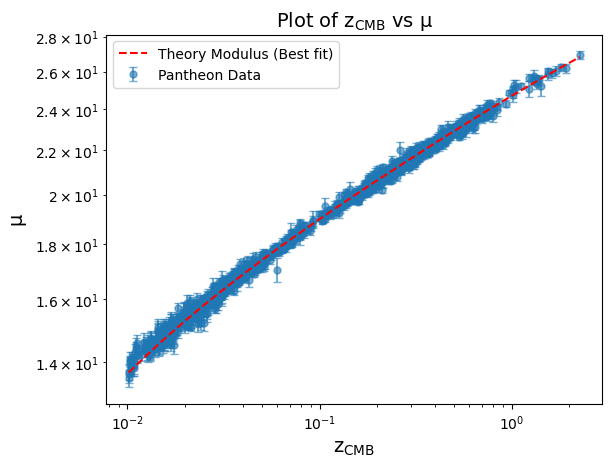

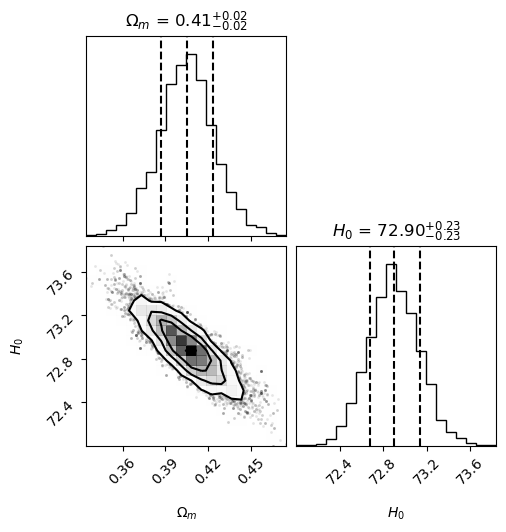

In [7]:
# Plot the data and the fit
plt.xscale('log')
plt.yscale('log')
plt.errorbar(zcmb, mbs, yerr=mbs_err, fmt='o', markersize=5, alpha=0.6, capsize=3, label='Pantheon Data')
distances_fit = transverse_distance(zcmb, omega_m_est, 1.0 - omega_m_est, 0.0, h0_est)
theory_modulus_fit = theory_modulus(zhel, distances_fit, M=-19.2)

plt.plot(zcmb, theory_modulus_fit, color='red', linestyle='--', label='Theory Modulus (Best fit)', zorder=10)
plt.xlabel('$\mathrm{z_{CMB}}$', fontsize=14)
plt.ylabel('$\mathrm{\mu}$', fontsize=14)
plt.title('Plot of $\mathrm{z_{CMB}}$ vs $\mathrm{\mu}$', fontsize=14)
plt.legend()
plt.savefig("Plots/data_and_fit_plot.pdf")
plt.show()

# Plot chains and corner plot
labels = [r"$\Omega_m$", r"$H_0$"]
# fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
# for i in range(ndim):
#     axes[i].plot(samples[:, i], color='k', alpha=0.3)
#     axes[i].set_ylabel(labels[i])
#     axes[i].yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("Step number")
# plt.savefig("chains_plot.pdf")
# plt.show()

# Corner plot
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True)
plt.savefig("Plots/LCDM.pdf")
plt.show()

In [8]:
# stack the best fit values to the data array
SN_dist = np.column_stack((zcmb, zhel, mbs, mbs_err, theory_modulus_fit))

In [9]:
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates import Galactic
from matplotlib.patches import Circle
from astropy.wcs import WCS
import matplotlib.pyplot as lab
from astropy import units as u
import healpy as hp # Healpy to me is avialable only in the base environment of the conda
from healpy import fitsfunc as ff


ra, dec = Set_SN(data_file_path, cov_file_path)[4:]
c = SkyCoord(ra = ra*u.degree,dec = dec*u.degree,frame = 'icrs')

ra_rad = c.ra.radian
ra_rad[ra_rad > np.pi] -= 2. * np.pi
dec_rad = c.dec.radian

c_gal = c.galactic
l_rad = c_gal.l.radian
l_rad[l_rad > np.pi] -= 2. * np.pi
b_rad = c_gal.b.radian

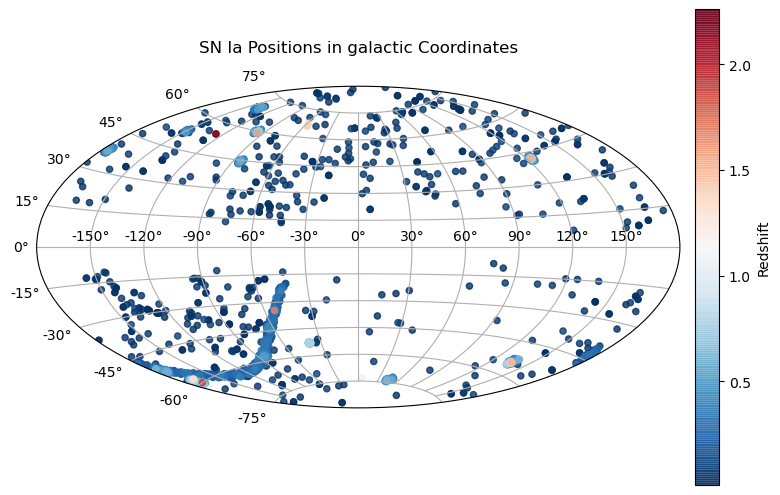

In [10]:
fig = plt.figure(figsize=(10,10/1.618))
ax = fig.add_subplot(1,1,1,projection="aitoff", aspect='equal')

plt.grid(True)

points = plt.scatter(-1.*l_rad, b_rad, marker = 'o',alpha = 0.8, s = 20,c=zcmb,cmap=plt.cm.RdBu_r)
plt.colorbar(points,orientation="vertical", pad=0.02, label = 'Redshift')
plt.title("SN Ia Positions in galactic Coordinates", y=1.08)
plt.show()

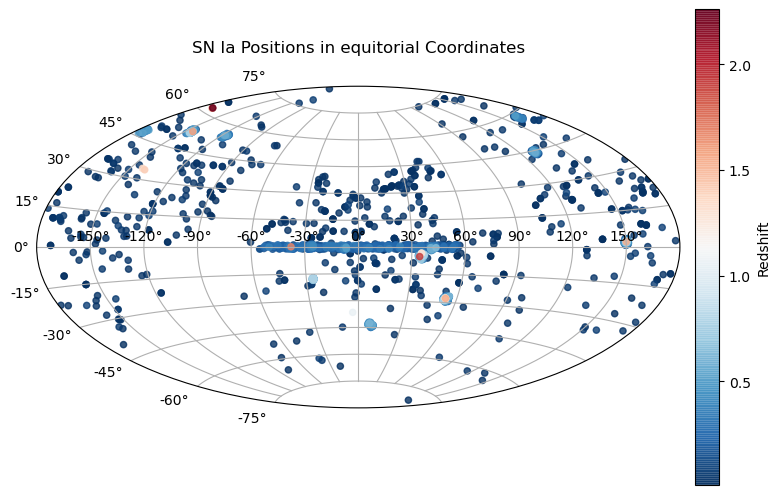

In [11]:
fig = plt.figure(figsize=(10,10/1.618))
ax = fig.add_subplot(1,1,1,projection="aitoff", aspect='equal')

plt.grid(True)

points = plt.scatter(ra_rad,dec_rad, marker = 'o',alpha = 0.8, s = 20,c=zcmb,cmap=plt.cm.RdBu_r)
plt.colorbar(points,orientation="vertical", pad=0.02, label = 'Redshift')
plt.title("SN Ia Positions in equitorial Coordinates", y=1.08)
plt.show()

In [12]:
## To initialise the Healpix maps
NSIDE = 16
print("Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60 ))
ls=np.arange(3*NSIDE)
Npix = hp.nside2npix(NSIDE)
# m = np.arange(Npix)
val = np.array([1.]*Npix)

Approximate resolution at NSIDE 16 is 3.7 deg


In [13]:
m = hp.ang2pix(nside=NSIDE,phi=dec ,theta=ra, lonlat=True)
m1 = m.tolist()

# define the mask 
arr = np.array([0.]*hp.nside2npix(NSIDE))
index = np.array([0.]*hp.nside2npix(NSIDE))

In [17]:
# compute the residuals and the mask
ri = (SN_dist[:,2]- SN_dist[:,4])/(SN_dist[:,3])
for i in range(len(SN_dist)):
    index[m1[i]] += 1.
    arr[m1[i]] += ri[i]

# To save the mask
ff.write_map('index.fits',index,nest=False,overwrite=True)

setting the output map dtype to [dtype('float64')]


In [18]:
arri = np.nan_to_num(arr/index)
# aars = hp.smoothing(arr/index,fwhm=np.radians(180./60.)) # smoothing the map

# alms = hp.map2alm(arr,use_weights=True) # convert to alm
# cls = np.zeros(len(ls))

plt.hist(ri,bins=30,label='Residuals')
plt.gca().legend()

/tmp/ipykernel_1500612/4149767521.py:1: RuntimeWarning: invalid value encountered in true_divide
  arri = np.nan_to_num(arr/index)


In [34]:
arr_mask = hp.ma(arr,badval=0,copy=True,)
arr_mask

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=0.0)

In [20]:
arri_mask = hp.ma(arri,badval=0,copy=True)
arri_mask

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=0.0)

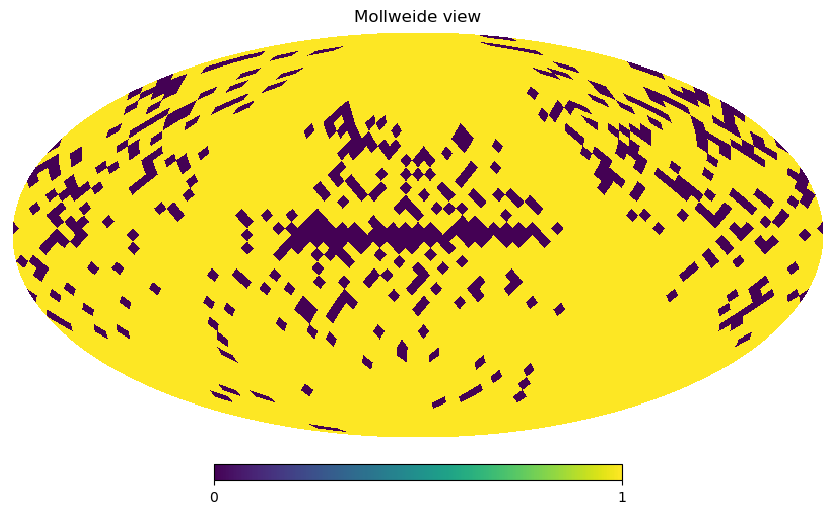

In [36]:
hp.mollview(arri_mask.mask,nest=False)

0.0 180.0 -180.0 180.0


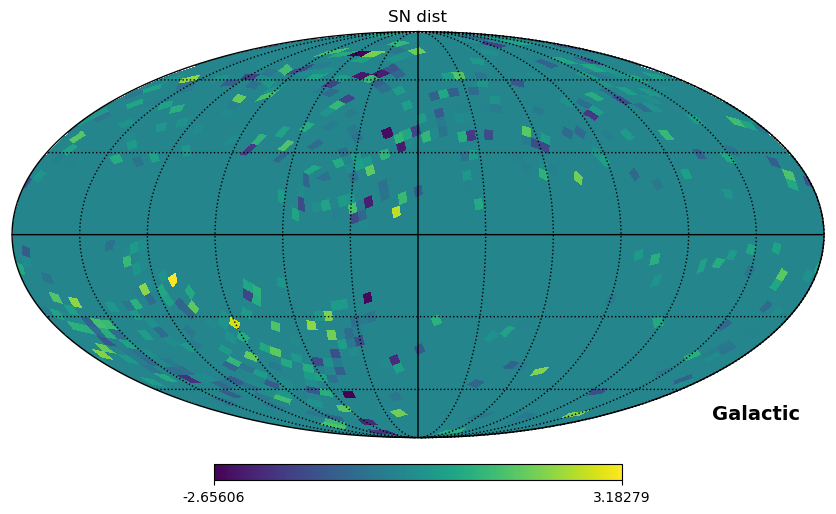

In [25]:
hp.mollview(arri_mask, title="SN dist",nest=False,coord=["E","G"]) #(,norm='hist',xsize=20000)
hp.graticule()

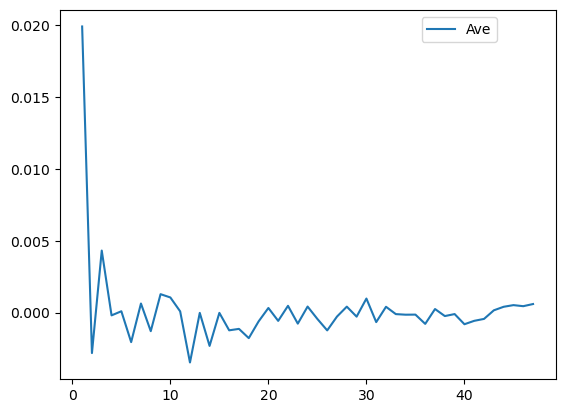

In [28]:
# To plots the cls of the maps
ls=np.arange(3*NSIDE)
#plt.plot(ls[1::],hp.anafast(arr_mask,index,use_weights=True)[1::], label='r')
plt.plot(ls[1::],hp.anafast(arri_mask,index,use_weights=True)[1::], label='Ave')
# plt.plot(ls[1::],hp.anafast(arrs_mask,index,use_weights=True)[1::], label='Ave2')
plt.legend(bbox_to_anchor=(0.73, 0.98), loc=2, borderaxespad=0.)

In [133]:
cmb = hp.read_map('./DATA/SMICA_16.fits')

In [134]:
cmb_mask = hp.ma(cmb,badval=0,copy=True,)

In [135]:
cmb_mask.mask = arri_mask.mask
cmb_mask = hp.smoothing(cmb_mask,fwhm=np.radians(30.))

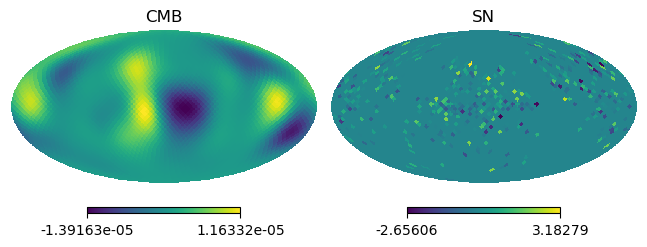

In [136]:
hp.mollview(cmb_mask,nest=False, title='CMB', sub=(1,2,1,))
hp.mollview(arri_mask,nest=False, title = 'SN', sub=(1,2,2,))

In [137]:
cmb_alm = hp.map2alm(cmb_mask,use_weights=True)
sn_alm = hp.map2alm(arri_mask,use_weights=True)

In [138]:
cl_cmb = hp.alm2cl(cmb_alm)
cl_sn = hp.alm2cl(sn_alm)
cl_cmb_sn = hp.alm2cl(cmb_alm,sn_alm)

In [139]:
normalized_cl_cmb_sn = cl_cmb_sn/np.sqrt(cl_cmb*cl_sn)

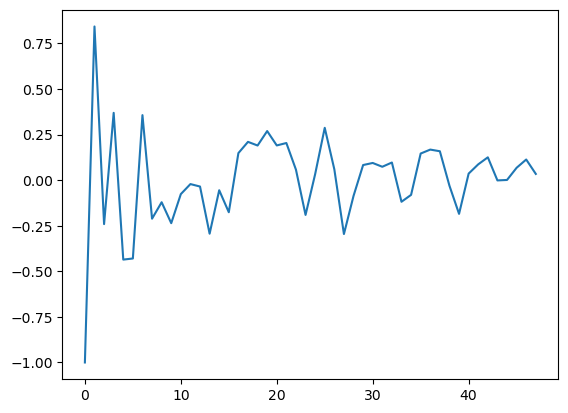

In [140]:
plt.plot(normalized_cl_cmb_sn, label='CMB x SN')

In [143]:
num_bootstrap = 1000
mask = arri_mask.mask
sn_ = np.array(arri_mask)
arri_masked_indexes = np.where(mask == False)[0]
bl = hp.gauss_beam(np.radians(60),lmax=3*NSIDE-1)

bootstrap_cross_power_spectra = []
bootstrap_sn_power_spectra = []

for _ in tqdm(range(num_bootstrap),desc='Bootstrap',unit='realization'):
    shuffled_indexes = np.random.permutation(arri_masked_indexes)
    sn_shuffled = np.zeros_like(sn_)
    sn_shuffled[arri_masked_indexes] = sn_[shuffled_indexes]

    sn_shuffled = hp.smoothing(hp.ma(sn_shuffled, badval=0, copy=True), fwhm=np.radians(30.))
    
    alm_arri_shuffled = hp.map2alm(sn_shuffled, use_weights=True)
    cl_arri_shuffled = hp.alm2cl(alm_arri_shuffled)
    
    cross_power_spectrum = hp.alm2cl(alm_arri_shuffled, cmb_alm)
    normalized_cross_power_spectrum = cross_power_spectrum / np.sqrt(cl_arri_shuffled * cl_cmb)
    
    sn_power_spectrum = np.real(hp.alm2cl(alm_arri_shuffled))
    
    bootstrap_cross_power_spectra.append(normalized_cross_power_spectrum)
    bootstrap_sn_power_spectra.append(sn_power_spectrum)
    
bootstrap_cross_power_spectra = np.array(bootstrap_cross_power_spectra)
bootstrap_sn_power_spectra = np.array(bootstrap_sn_power_spectra)

Bootstrap:   4%|▎         | 37/1000 [00:00<00:05, 181.93realization/s]

Bootstrap: 100%|██████████| 1000/1000 [00:04<00:00, 202.29realization/s]


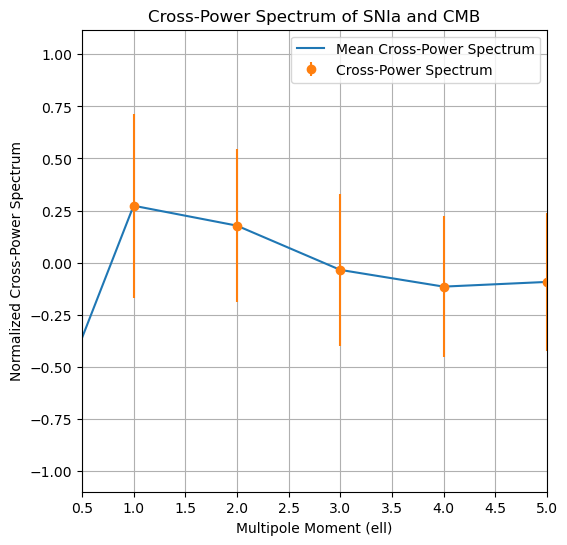

In [152]:
mean_cross_power_spectrum = np.mean(bootstrap_cross_power_spectra, axis=0)
std_cross_power_spectrum = np.std(bootstrap_cross_power_spectra, axis=0)


ell_values = np.arange(len(mean_cross_power_spectrum))


plt.figure(figsize=(6, 6))
plt.plot(ell_values, mean_cross_power_spectrum, label='Mean Cross-Power Spectrum')
plt.errorbar(ell_values, mean_cross_power_spectrum, yerr=std_cross_power_spectrum, fmt='o', label='Cross-Power Spectrum')
#plt.fill_between(ell_values, mean_cross_power_spectrum - std_cross_power_spectrum, mean_cross_power_spectrum + std_cross_power_spectrum, alpha=0.3, label='Std Dev')
plt.xlabel('Multipole Moment (ell)')
plt.ylabel('Normalized Cross-Power Spectrum')
plt.title('Cross-Power Spectrum of SNIa and CMB')
plt.legend()
plt.xlim(.5, 5)
plt.grid()
plt.show()

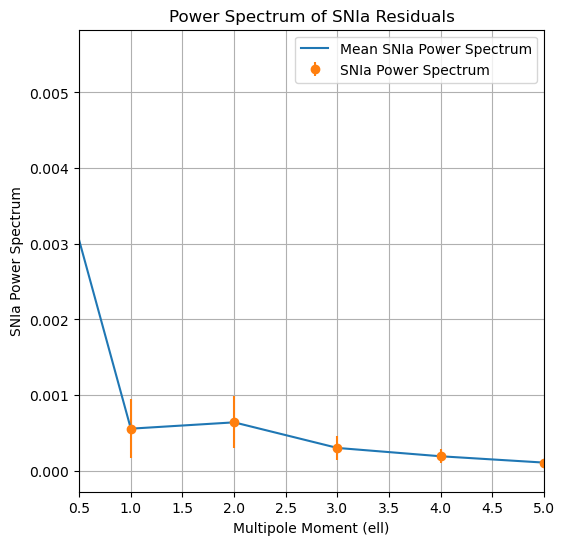

In [151]:
mean_sn_power_spectrum = np.mean(bootstrap_sn_power_spectra, axis=0)
std_sn_power_spectrum = np.std(bootstrap_sn_power_spectra, axis=0)


ell_values = np.arange(len(mean_sn_power_spectrum))


plt.figure(figsize=(6, 6))
plt.plot(ell_values, mean_sn_power_spectrum, label='Mean SNIa Power Spectrum')
plt.errorbar(ell_values, mean_sn_power_spectrum, yerr=std_sn_power_spectrum, fmt='o', label='SNIa Power Spectrum')
#plt.fill_between(ell_values, mean_sn_power_spectrum - std_sn_power_spectrum, mean_sn_power_spectrum + std_sn_power_spectrum, alpha=0.3, label='Std Dev')
plt.xlabel('Multipole Moment (ell)')
plt.ylabel('SNIa Power Spectrum')
plt.title('Power Spectrum of SNIa Residuals')
plt.legend()
plt.xlim(0.5, 5)
plt.grid()
plt.show()

In [117]:
std_cross_power_spectrum

array([1.13234585e-16, 4.42775207e-01, 3.68615814e-01, 3.74699922e-01,
       3.37254010e-01, 3.31296075e-01, 2.96232043e-01, 2.76579998e-01,
       2.62745953e-01, 2.52753816e-01, 2.40647399e-01, 2.21440825e-01,
       2.09158569e-01, 2.05248278e-01, 1.92738096e-01, 1.81315267e-01,
       1.78795507e-01, 1.74622039e-01, 1.63854006e-01, 1.70201373e-01,
       1.67360089e-01, 1.56107162e-01, 1.55742299e-01, 1.48233818e-01,
       1.48978554e-01, 1.51590560e-01, 1.41029194e-01, 1.57647825e-01,
       1.36426287e-01, 1.40431454e-01, 1.41121366e-01, 1.39321989e-01,
       1.29720382e-01, 1.35431806e-01, 1.32274652e-01, 1.24604213e-01,
       1.30351562e-01, 1.22941558e-01, 1.24895964e-01, 1.22657608e-01,
       1.26276205e-01, 1.19878308e-01, 1.13579120e-01, 1.13947268e-01,
       1.10199196e-01, 1.13379787e-01, 1.16453893e-01, 1.16236916e-01])